# Estimating Causal Effect towards individual Resilience to risks globally
Code authored by: Minh Kieu, UoA, 2023 <br />
DoWhy Library: https://microsoft.github.io/dowhy/ <br />
Data from: https://wrp.lrfoundation.org.uk

#### Version 2:
- We do not remove variables that are already in the Perception and Experience indices

### Import libraries

In [1]:
#data modules
import pandas as pd 
import pickle
import pyreadstat

#Causal Discover modules
from pgmpy.estimators import HillClimbSearch, BicScore
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

#Causal Inference modules
from sklearn.ensemble import RandomForestRegressor
import econml
import dowhy
from dowhy import CausalModel




/Users/mkie815/opt/anaconda3/envs/causal/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data


In [10]:
df, meta = pyreadstat.read_sav("../Data/lrf_wrp_2021_full_data.sav")
#filter out countries with number of data points less than 1200
df = df.groupby('Country').filter(lambda x: x['Country'].count() >= 1200)
df_1=df[df['Q1'].isnull()]
#drop all columns from 'resilience_index' to 'Q5F_2019'
df = df.drop(df.loc[:,'resilience_index':'Q5F_2019'].columns, axis=1)
cols_to_remove = ['WPID_RANDOM','WP5','WGT','Year','country.in.both.waves','CountryIncomeLevel2019','PROJWT_2021','PROJWT_2019','AgeGroups4']
df= df.drop(cols_to_remove, axis=1)
df.head(2)

,Country,GlobalRegion,CountryIncomeLevel2021,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,...,Q22A,Q22B,Q22C,Q22D,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E
0,United States,6.0,4.0,70.0,1.0,1.0,2.0,2.0,6.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,United States,6.0,4.0,56.0,1.0,3.0,1.0,5.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [5]:
x=df.loc[df.Country=='United Arab Emirates']

## Step 1: Estimate the values of Perception, Experience and Resilience index

#### For given risk (eg: crime)
$$\text{Perception Index (given country)} = \text{avg of individual perception scores of a country}$$
$$\text{Experience Index (given country)} = \text{avg of individual experience scores of a country}$$
$$\text{Risk Impact Index (individual)} = \text{experience score} \times \text{perception score}$$


#### Resilience index for all seven risks
$$\text{Resilience Index (individual)} = \text{Average of all the individual response to Resilience-related questions} $$

- To calculate the perception score, the weitages are  very worried = 1, somewhat worried = 0.5, not worried = 0, and DK & refused = missing 

- To calculate the experience score, the weitages are  Both = 1, Yes,personally experienced = 0.75, Yes,know someone who has experienced = 0.5, No = 0, and DK & refused = missing 

### Step 1.1: First, let's estimate the Perception, Experience and Risk Impact Index

In [3]:
import numpy as np 

perception_df=df[['GlobalRegion','Country', 'Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].copy()

# Replace Don't know and Refuse to answer response to NaN
cols_to_replace = ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']
replace_dict = {98: np.nan, 99: np.nan}
perception_df[cols_to_replace] = perception_df[cols_to_replace].replace(replace_dict)

#removing the raws if all the columns have missing values, 98, 99 
perception_df.dropna(subset=['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G'], thresh=7, inplace=True)

# replace the values 2 with 0.5 and 3 with 0
perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']] = perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].replace({2: 0.5, 3: 0})
perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']] = perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].replace({3: 1, 1: 0.75, 2: 0.5, 4: 0})

# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# create a new column with the computed average
perception_df['Perception_index'] = perception_df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].apply(compute_average, axis=1)
perception_df['Experience_index'] = perception_df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].apply(compute_average, axis=1)
#perception_df['Impact_index'] = perception_df['Perception_index'] * perception_df['Experience_index']
perception_df.head(2)


,GlobalRegion,Country,Q4A,Q4B,Q4C,Q4D,Q4E,Q4F,Q4G,Q5A,Q5B,Q5C,Q5D,Q5E,Q5F,Q5G,Perception_index,Experience_index
0,6.0,United States,1.0,1.0,1.0,1.0,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0
1,6.0,United States,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.0


Now we can drop the individual questions related to Perception and Experience 

In [4]:
#df= df.drop(cols_to_replace, axis=1)
df = df.join(perception_df[['Perception_index','Experience_index']])
df.head(2)

,WPID_RANDOM,WP5,Country,WGT,Year,GlobalRegion,country.in.both.waves,CountryIncomeLevel2021,CountryIncomeLevel2019,PROJWT_2021,...,REGION_ZWE,Q2_1_2019A,Q2_1_2019B,Q5A_2019,Q5B_2019,Q5C_2019,Q5D_2019,Q5F_2019,Perception_index,Experience_index
0,174262180.0,1.0,United States,2.132627,2021.0,6.0,1.0,4.0,NaN,562058.627707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.0
1,115327451.0,1.0,United States,0.620385,2021.0,6.0,1.0,4.0,NaN,163503.920074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,0.0


In [5]:
#df2 = df.drop(df.iloc[:, 68:194],axis = 1)
#cols_to_remove = ['WPID_RANDOM','WP5','WGT','Year','country.in.both.waves','CountryIncomeLevel2021','CountryIncomeLevel2019','PROJWT_2021','PROJWT_2019','AgeGroups4','HouseholdSize','Q2_1','Q3','Q6','Q7A','Q7C','resilience_index','Worried.Index','Experienced.Index','worry_exp_gap']
df2 = df2.drop(cols_to_remove,axis=1)
df2.head(2)

KeyError: "['resilience_index' 'Worried.Index' 'Experienced.Index' 'worry_exp_gap'] not found in axis"

### Step 1.2: Now let' estimate the value of Resilience index

In [9]:
index_resi=df[['GlobalRegion','Country', 'Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']].copy()

# replace DOn't know and Refuse to answer to NaN
cols_to_replace = ['Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']
replace_dict = {98: np.nan, 99: np.nan}
index_resi[cols_to_replace] = index_resi[cols_to_replace].replace(replace_dict)


# replace the values 2 with 0.5 and 3 with 0
index_resi.loc[:, ['Q13']] = index_resi.loc[:, ['Q13']].replace({2: 0.5, 3: 0})
index_resi.loc[:, ['Q10Q11Recode']] = index_resi.loc[:, ['Q10Q11Recode']].replace({1: 0.1, 2: 0.2, 3: 0.3, 4: 0.4, 5: 0.5, 6: 0.8, 7: 0.9, 8: 1, 9: 0.7})
index_resi.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']] = index_resi.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']].replace({3: 0.5, 2: 0})
index_resi.loc[:, ['Q21']] = index_resi.loc[:, ['Q21']].replace({2: 0})

# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# create a new column with the computed average
# index['individual_score'] = index.loc[:, []].apply(compute_average, axis=1)
#index_resi['household_score'] = index_resi.loc[:, ['Q21','Q10Q11Recode','Q16C']].apply(compute_average, axis=1)
#index_resi['community_score'] = index_resi.loc[:, ['Q13', 'Q16D']].apply(compute_average, axis=1)
#index_resi['society_score'] = index_resi.loc[:, ['Q16A','Q16B']].apply(compute_average, axis=1)

# Calculating individual resilience score
index_resi['Resilience_index'] = index_resi.loc[:, cols_to_replace].apply(compute_average, axis=1)
index_resi.head(2)

,GlobalRegion,Country,Q20,Q21,Q10Q11Recode,Q16C,Q13,Q16D,Q16A,Q16B,Resilience_index
0,6.0,United States,1.0,1.0,0.8,1.0,1.0,0.0,0.0,1.0,0.725
1,6.0,United States,1.0,1.0,0.8,1.0,1.0,1.0,0.0,1.0,0.850


In [10]:
# Merge Resilience index to the main dataframe
df2= df2.drop(cols_to_replace, axis=1)
df2 = df2.join(index_resi[['Resilience_index']])
df2.head(2)


,Country,GlobalRegion,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,ChildrenInHousehold,...,Q22D,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E,Perception_index,Experience_index,Resilience_index
0,United States,6.0,70.0,1.0,1.0,2.0,2.0,6.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.750000,0.0,0.725
1,United States,6.0,56.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.214286,0.0,0.850


Now let's do some more data cleaning 

In [11]:
#Drop some less related columns
#df2=df2.drop(['Q10','Q11_1','Q11_2','Q15','Q22A', 'Q22B', 'Q22C', 'Q22D','Q22E','Q17'],axis=1)
df2=df2.drop(['Q10','Q11_1','Q11_2'],axis=1)

df2=df2.dropna(thresh=df2.shape[0]*0.3,how='all',axis=1)
df2=df2.fillna(df2.mean())

Let's simplify the data by converting to majorly continuous or binary

In [12]:
df2['isMale'] = df2['Gender'].apply(lambda x: 1 if x == 1 else 0).astype('uint8')

#Remove the don't know or refuse to answer samples
df2['ChildrenInHousehold']=df2['ChildrenInHousehold'].astype('uint8')
df2['Country']=df2['Country'].astype('category')
df2['GlobalRegion']=df2['GlobalRegion'].astype('uint8')
df2['INCOME_5']=df2['INCOME_5'].astype('uint8')
df2['EMP_2010']=df2['EMP_2010'].astype('uint8')
df2 = df2.loc[df2['Age']<99,:]
df2['Age']=df2['Age'].astype('uint8')
df2 = df2.loc[df2['Education']<9,:]
df2['Education']=df2['Education'].astype('uint8')
df2 = df2.loc[df2['IncomeFeelings']<5,:]
df2['IncomeFeelings']=df2['IncomeFeelings'].astype('uint8')
df2 = df2.loc[df2['Urbanicity']<9,:]
df2['Urbanicity']=df2['Urbanicity'].astype('uint8')
df2 = df2.loc[df2['Q8']<9,:]
df2 = df2.loc[df2['Q14A']<9,:]
df2 = df2.loc[df2['Q14B']<9,:]
df2 = df2.loc[df2['Q14C']<9,:]
df2 = df2.loc[df2['Q14D']<9,:]
df2 = df2.loc[df2['Q14E']<9,:]
df2 = df2.loc[df2['Q14F']<9,:]
df2 = df2.loc[df2['Q14G']<9,:]
df2 = df2.loc[df2['Q17']<9,:]
df2 = df2.loc[df2['Q22A']<9,:]
df2 = df2.loc[df2['Q22B']<9,:]
df2 = df2.loc[df2['Q22C']<9,:]
df2 = df2.loc[df2['Q22D']<9,:]
df2 = df2.loc[df2['Q23A']<9,:]
df2 = df2.loc[df2['Q23B']<9,:]
df2 = df2.loc[df2['Q23C']<9,:]
df2 = df2.loc[df2['Q23D']<9,:]
df2 = df2.loc[df2['Q23E']<9,:]


#Convert some categorical data into numeric

df2.loc[:, ['Q1']] = df2.loc[:, ['Q1']].replace({3: 1, 2: 0, 98: 0, 99: 0}).astype('uint8')
df2.loc[:, ['Q9']] = df2.loc[:, ['Q9']].replace({2: 0, 3: 0.5, 4: 0.5, 98: 0.5, 99: 0.5})
df2.loc[:, ['Q8']] = df2.loc[:, ['Q8']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14A']] = df2.loc[:, ['Q14A']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14B']] = df2.loc[:, ['Q14B']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14C']] = df2.loc[:, ['Q14C']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14D']] = df2.loc[:, ['Q14D']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14E']] = df2.loc[:, ['Q14E']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14F']] = df2.loc[:, ['Q14F']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q14G']] = df2.loc[:, ['Q14G']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q17']] = df2.loc[:, ['Q17']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q22A']] = df2.loc[:, ['Q22A']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q22B']] = df2.loc[:, ['Q22B']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q22C']] = df2.loc[:, ['Q22C']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q22D']] = df2.loc[:, ['Q22D']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q23A']] = df2.loc[:, ['Q23A']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q23B']] = df2.loc[:, ['Q23B']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q23C']] = df2.loc[:, ['Q23C']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q23D']] = df2.loc[:, ['Q23D']].replace({2: 0}).astype('uint8')
df2.loc[:, ['Q23E']] = df2.loc[:, ['Q23E']].replace({2: 0}).astype('uint8')

df2 = df2.drop(['Gender'],axis=1)

In [13]:
df2.columns

Index(['Country', 'GlobalRegion', 'Age', 'Education', 'IncomeFeelings',
       'INCOME_5', 'EMP_2010', 'Urbanicity', 'ChildrenInHousehold', 'Q1', 'Q8',
       'Q9', 'Q14A', 'Q14B', 'Q14C', 'Q14D', 'Q14E', 'Q14F', 'Q14G', 'Q15',
       'Q17', 'Q22A', 'Q22B', 'Q22C', 'Q22D', 'Q22E', 'Q23A', 'Q23B', 'Q23C',
       'Q23D', 'Q23E', 'Perception_index', 'Experience_index',
       'Resilience_index', 'isMale'],
      dtype='object')

In [26]:
df2.columns = ['Country', 'Region', 'Age', 'Education', 'IncomePerception',
       'IncomeBracket', 'Employment', 'Urbanicity', 'Child', 'MoreOrLessSafe', 'AV_Trust',
       'AI_Trust', 'Info_weather', 'Info_agency', 'Info_News', 'Info_religion', 'Info_famous', 'Info_services', 'Info_internet','TrustMost','Disaster','WithoutElectricity','WithoutWater','WithoutFood','WithoutMedicine','WithoutTelephone',
       'DiscriminationSkin', 'DiscriminationReligion', 'DiscriminationEthic', 'DiscriminationGender',
       'DiscriminationDisability', 'Perception_ind', 'Experience_ind','Resilience_ind', 'isMale']
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82386 entries, 0 to 125910
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Country                   82386 non-null  category
 1   Region                    82386 non-null  uint8   
 2   Age                       82386 non-null  uint8   
 3   Education                 82386 non-null  uint8   
 4   IncomePerception          82386 non-null  uint8   
 5   IncomeBracket             82386 non-null  uint8   
 6   Employment                82386 non-null  uint8   
 7   Urbanicity                82386 non-null  uint8   
 8   Child                     82386 non-null  uint8   
 9   MoreOrLessSafe            82386 non-null  uint8   
 10  AV_Trust                  82386 non-null  uint8   
 11  AI_Trust                  82386 non-null  float64 
 12  Info_weather              82386 non-null  uint8   
 13  Info_agency               82386 non-null  uin

## Step 2: Perform Causal Discovery using a Bayesian Network

Bayesian networks (BNs) can be used for causal discovery from observational data. In fact, they are one of the primary tools for this task.

A Bayesian network is a directed acyclic graph (DAG) that represents the joint probability distribution over a set of variables. Each node in the graph corresponds to a variable, and the edges between the nodes represent probabilistic dependencies between the variables.

Causal discovery is primarily concerned with the first phase of Bayesian network modeling, which is learning the structure or the graphical representation. The learned graph from this phase often represents a causal structure, where the nodes represent variables and the edges represent causal relationships.

The structural learning process is able to identify these relationships and the direction of influence based on the patterns and dependencies in the data, which makes it a powerful tool for causal discovery.

However, it's important to note that while this structure can suggest causal relationships, it does not definitively prove them. There might be hidden or latent variables not included in the data that can influence the relationships. Therefore, any causal conclusions should be drawn cautiously and, ideally, should be supported by domain knowledge or further experimentation.


#### first, let's try HillClimbing Search to develop the DAG



In [29]:
# Use Hill Climb Search to develop the BN structure, then BicScore to estimate the parameters for our BN
np.random.seed(123)  # Set the seed to an arbitrary number
hc = HillClimbSearch(df2)
bic = BicScore(df2)
best_model = hc.estimate(scoring_method=bic)

  0%|          | 72/1000000 [02:40<620:56:27,  2.24s/it] 


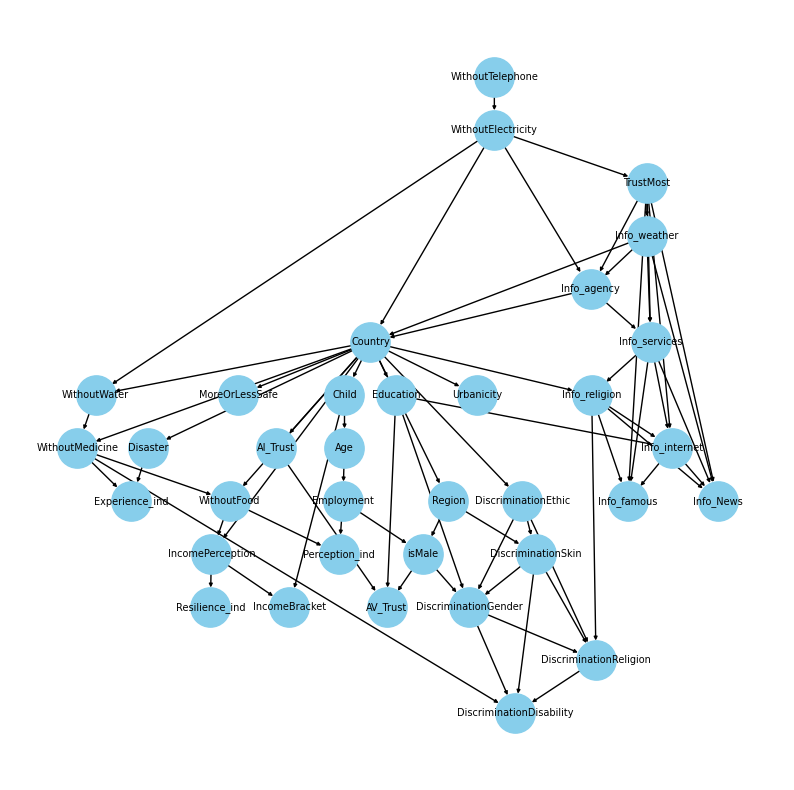

In [30]:
# Now we can visualise the BN
# Create a new graph and add edges
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

# Use pygraphviz to create the layout
pos = graphviz_layout(G, prog='dot')

fig, ax = plt.subplots(figsize=(10,10))

nx.draw(G, pos, with_labels=True, arrowsize=5, node_size=800, node_color = '#87CEEB', alpha=1, font_size=7, ax=ax)

plt.savefig('../Figures/causalnetwork.pdf',bbox_inches='tight')
plt.show()


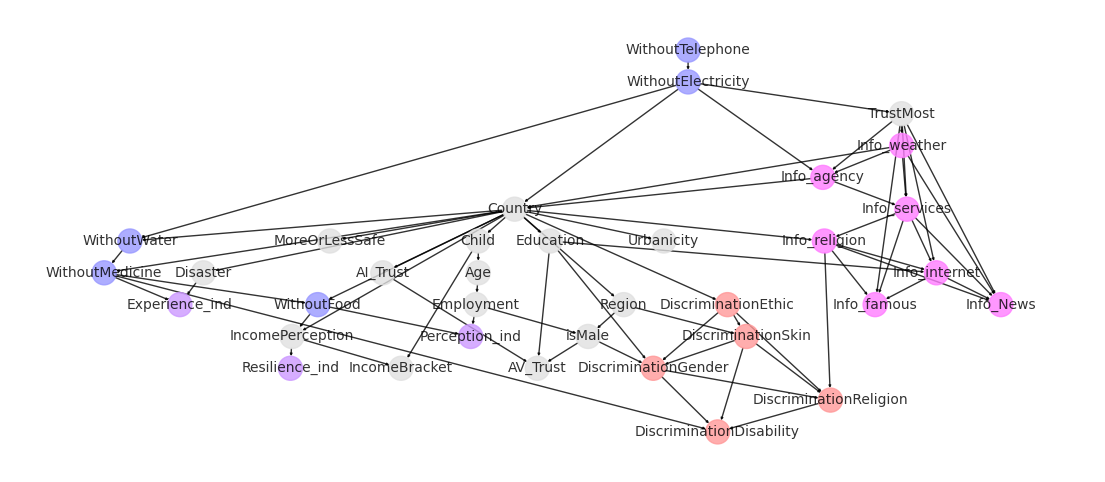

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,6))


# assign colors to nodes based on their names
colors = []
for node in G.nodes():
    if 'Without' in node:
        colors.append('#9999FF')
    elif '_ind' in node:
        colors.append('#CC99FF')
    elif 'Info_' in node:
        colors.append('#FF7DFF')
    elif 'Discrimination' in node:
        colors.append('#FF9999')
    elif 'n_' in node:
        colors.append('#CCFFCC')
    elif 'o_' in node:
        colors.append('#FFFF2B')
    else:    
        colors.append('#E0E0E0')

nx.draw(G, pos, with_labels=True, arrowsize=3, node_size=300, node_color = colors, alpha=0.8, font_size=10, ax=ax)

plt.savefig('../Figures/causalnetwork.pdf',bbox_inches='tight')
plt.show()

In [18]:
with open("../Data/DAG.gpickle", 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

# load later by using:
#with open("../Data/DAG.gpickle", 'rb') as f:
#    G = pickle.load(f)


Try to learn the DAG structure using the PC (Constraint-based Search) instead

### Note: Only run on a HPC as this method takes forever! 

In [17]:
#from pgmpy.estimators import PC

# Use Hill Climb Search to develop the BN structure, then BicScore to estimate the parameters for our BN
#hc = PC(df2)
#bic = BicScore(df2)
#best_model = hc.estimate(scoring_method=bic)


In [32]:
print(best_model.edges())


[('Country', 'Region'), ('Country', 'Education'), ('Country', 'IncomePerception'), ('Country', 'WithoutWater'), ('Country', 'Child'), ('Country', 'Info_religion'), ('Country', 'WithoutMedicine'), ('Country', 'Urbanicity'), ('Country', 'AI_Trust'), ('Country', 'DiscriminationEthic'), ('Country', 'Disaster'), ('Country', 'MoreOrLessSafe'), ('Country', 'WithoutFood'), ('Region', 'DiscriminationSkin'), ('Region', 'isMale'), ('Age', 'Employment'), ('Education', 'Info_internet'), ('Education', 'DiscriminationGender'), ('Education', 'AV_Trust'), ('IncomePerception', 'IncomeBracket'), ('IncomePerception', 'Resilience_ind'), ('Employment', 'Perception_ind'), ('Employment', 'isMale'), ('Child', 'Age'), ('Child', 'IncomeBracket'), ('AI_Trust', 'AV_Trust'), ('Info_weather', 'Info_agency'), ('Info_weather', 'Country'), ('Info_weather', 'Info_News'), ('Info_weather', 'Info_services'), ('Info_agency', 'Country'), ('Info_agency', 'Info_services'), ('Info_religion', 'Info_famous'), ('Info_religion', 'I

## Step 3: Estimating Causal Effects with DoWhy 

Code adopted from: https://microsoft.github.io/dowhy/example_notebooks/dowhy-conditional-treatment-effects.html

#### Step 3.1: causal model for Experience index

Load the finished DAG if you have run it

In [2]:
# load later by using:
with open("../Data/DAG.gpickle", 'rb') as f:
    G = pickle.load(f)

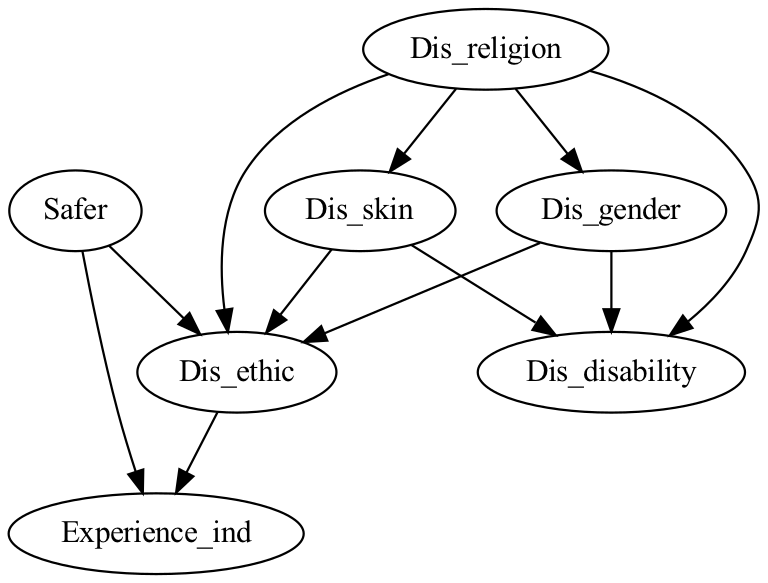

In [19]:
graph = """
digraph {
    Safer -> Dis_ethic;
    Safer -> Experience_ind;
    Dis_ethic->Experience_ind;
    Dis_gender->Dis_ethic;
    Dis_religion -> Dis_gender;
    Dis_religion -> Dis_skin;
    Dis_religion -> Dis_ethic;
    Dis_skin -> Dis_ethic;
    Dis_gender->Dis_disability;
    Dis_skin->Dis_disability;
    Dis_religion->Dis_disability;
}
"""
model = CausalModel(
    data=df2,
    treatment='Dis_ethic',
    outcome='Experience_ind',
    graph=graph
)

# View model
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [22]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Your code here

# Identifying the estimand
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.econml.metalearners.TLearner",
                                 target_units="ate",
                                 method_params={"init_params":{'models': RandomForestRegressor()},
                                                "fit_params":{}})
# Printing the causal effect
print(estimate.value)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.1166999627720946


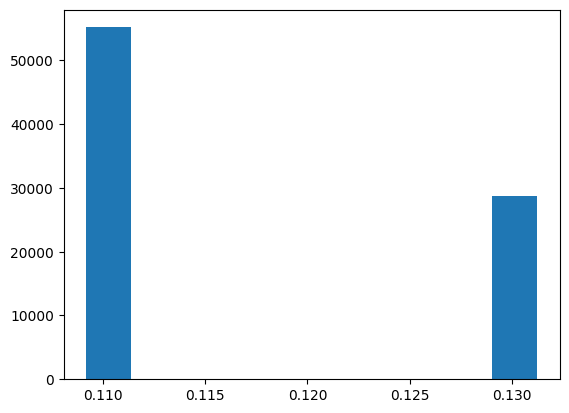

In [21]:
# print histogram of causal effects for each sample
plt.hist(estimate.cate_estimates,bins=10)

CATE_experience = estimate.cate_estimates

#### Step 3.2: Causal estimation for Perception index

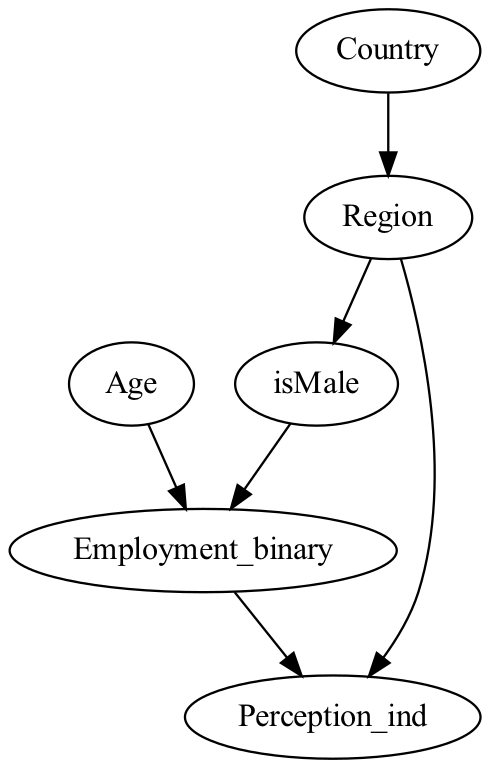

In [23]:
df2['Employment_binary'] = df2['Employment'].apply(lambda x: 1 if x < 3 else 0).astype('uint8')

graph = """
digraph {
    Age -> Employment_binary;
    Employment_binary -> Perception_ind;
    isMale->Employment_binary; 
    Region-> Perception_ind;
    Region -> isMale;
    Country->Region;
}
"""
model = CausalModel(
    data=df2,
    treatment='Employment_binary',
    outcome='Perception_ind',
    graph=graph
)

# View model
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [24]:

# Identifying the estimand
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.econml.metalearners.TLearner",
                                 target_units="ate",
                                 method_params={"init_params":{'models': RandomForestRegressor()},
                                                "fit_params":{}})
# Printing the causal effect
print(estimate.value)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


-0.022909166757132608


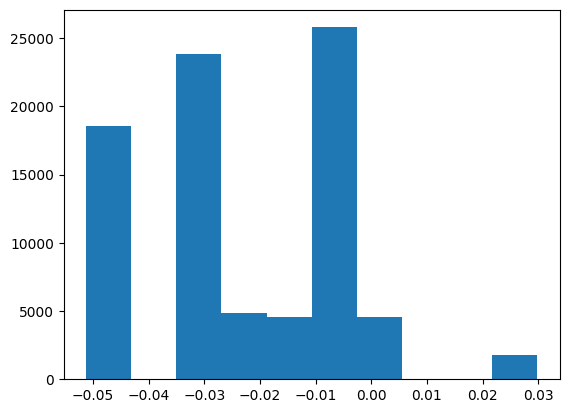

In [25]:
# print histogram of causal effects for each sample
plt.hist(estimate.cate_estimates,bins=10)

CATE_perception = estimate.cate_estimates

#### Step 3.3: Causal estimation for Resilience index

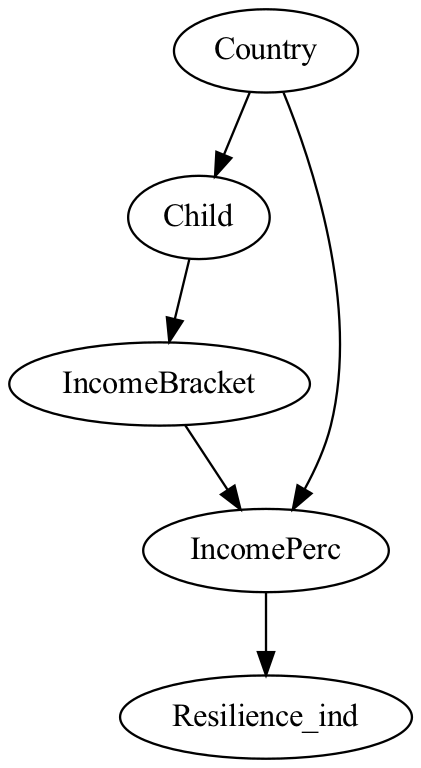

In [27]:
df2['IncomePerc_binary'] = df2['IncomePerc'].apply(lambda x: 1 if x < 3 else 0).astype('uint8')
#df2['IncomePerc_binary'] = df2['IncomePerc']
graph = """
digraph {
    Child->IncomeBracket
    IncomePerc -> Resilience_ind;
    IncomeBracket -> IncomePerc;
    Country->IncomePerc;
    Country-> Child;
    }
"""
#Country->IncomePerc_binary; ;
#Country-> Child;

model = CausalModel(
    data=df2,
    treatment='IncomePerc_binary',
    outcome='Resilience_ind',
    graph=graph
)

# View model
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [30]:
from econml.metalearners import TLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming `df` is your DataFrame and `cat_var` is your categorical variable
df_encoded = pd.get_dummies(df2['Country'])

# Choose a set of control variables
X = pd.concat([df2[['IncomeBracket','Child']], df_encoded], axis=1)

#df2[['IncomeBracket','Child']]

# Choose the treatment variable
T = df2['IncomePerc_binary']

# Choose the outcome variable
Y = df2['Resilience_ind']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42)

# Define the learner models
learner = RandomForestRegressor()

# Instantiate the TLearner class with the learner models
T_learner = TLearner(models=learner)

# Reshape treatment to be 2D
T_train_2D = np.array(T_train).reshape(-1, 1)

# Fit the model
T_learner.fit(Y=Y_train, T=T_train_2D, X=X_train)

# Estimate the CATE with the test set
cate_test = T_learner.effect(X=X_test)

# Print the CATE
print(cate_test)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[ 0.06702097  0.11723578  0.07741384 ...  0.13972774 -0.00997006
 -0.02641765]


(array([1.4000e+01, 5.7000e+01, 5.7600e+02, 2.7920e+03, 1.2849e+04,
        3.5091e+04, 2.5456e+04, 5.7810e+03, 1.1250e+03, 2.2900e+02]),
 array([-0.58116702, -0.46458956, -0.3480121 , -0.23143464, -0.11485718,
         0.00172028,  0.11829774,  0.2348752 ,  0.35145265,  0.46803011,
         0.58460757]),
 <BarContainer object of 10 artists>)

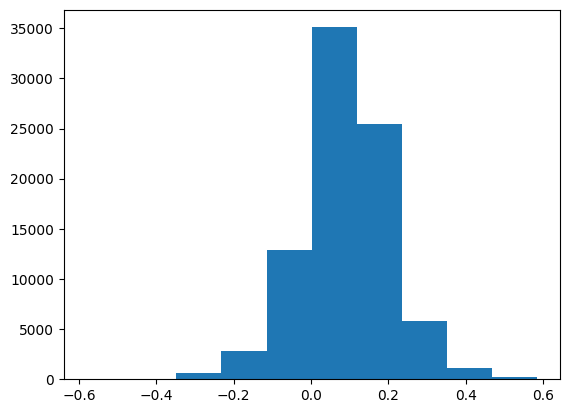

In [31]:
# Estimate the CATE with the test set
CATE_resilience = T_learner.effect(X=X)

# print histogram of causal effects for each sample
plt.hist(CATE_resilience,bins=10)


In [32]:
# Calculate the ATE
ate = np.mean(CATE_resilience)

# Print the ATE
print("ATE:", ate)

ATE: 0.09004026155392042


#### Step 3.4: Perform refutation sensitivity analysis with resilience 

In [263]:
from econml.interpreters import SingleTreeCateInterpreter

# Instantiate the SingleTreeCateInterpreter class
interpreter = SingleTreeCateInterpreter(include_model_uncertainty=True)

# Perform refutation sensitivity analysis
refutation_results = interpreter.interpret(T_learner, X_train, alpha=0.05, n_bootstraps=100)

# Print the results
print("Refutation Results:")
print(refutation_results.summary())


ModuleNotFoundError: No module named 'econml.interpreters'

*Sensitivity Analysis*: The estimate object also has a sensitivity method that can be used to conduct a sensitivity analysis. This can tell you how robust your results are to potential violations of the assumptions behind causal inference (e.g., the unconfoundedness assumption).

The sensitivity analysis can give you more confidence in your results or suggest that they should be interpreted with caution.

Remember that all of these results are based on the assumptions you made when setting up your causal model, including the choice of treatment and outcome variables, the selection of covariates, and the assumption of unconfoundedness. Always critically assess these assumptions when interpreting your results.


- Refute: Add a random common cause
- Estimated effect:-0.049451366969192764
- New effect:-0.05351417843313906
- p value:0.6399999999999999

The sensitivity analysis you've run, "Add a random common cause", is a method of testing the robustness of your causal effect estimate. 

The idea behind this test is to add a random variable (which should theoretically be unrelated to any other variables in the data) to your model as a common cause (a variable that influences both the treatment and outcome). If the causal effect estimate changes substantially with the addition of this random variable, it suggests that the original estimate may not be robust and could be susceptible to unobserved confounding. In other words, there could be some omitted variable that, if included in the model, would change the estimated causal effect.

In your case, the estimated effect was originally -0.04945, and with the addition of a random common cause, the effect is -0.05351. The effect has changed slightly but not dramatically. 

The p-value represents the statistical significance of the difference between the original estimate and the new estimate. A p-value greater than 0.05 (common threshold) typically indicates that the difference is not statistically significant. In your case, with a p-value of approximately 0.64, we would not consider the change in the estimated effect to be statistically significant.

Given these results, it seems like your original causal estimate is relatively robust to the addition of a random common cause. This suggests that your findings might also be robust to some potential omitted variables. However, remember that no sensitivity analysis can fully guard against the risk of unobserved confounding, and they are a way to gauge, not confirm, the robustness of your results. 

Always interpret the results in the context of your knowledge about the subject matter, as well as the limitations of your data and the assumptions of your model.


The Conditional Average Treatment Effect (CATE) refers to the average treatment effect conditional on covariates or features. In other words, instead of a single average effect across the entire population (as in ATE), CATE allows us to understand how the treatment effect varies across different subgroups or individuals, based on their characteristics.

For example, consider a scenario where we're evaluating an educational intervention. The ATE would tell us the average impact of the intervention on students' grades, while the CATE could tell us how the impact of the intervention differs between high school and elementary school students.

In the context of your data, once you have an estimate of the CATE, you can examine the treatment effect for different subgroups of individuals defined by their covariates.

You could, for instance, plot the estimated CATE against one or more covariates to visually inspect how the treatment effect varies with these variables. Another approach might be to calculate summary statistics (mean, median, etc.) of the estimated CATE for different subgroups.

## Step 4: Save the causal inference results

Note that the causal network DAG has already been saved to `DAG.gpickle`

In [33]:
np.savetxt("../Data/CATE_perception.csv", CATE_perception, delimiter=",")
np.savetxt("../Data/CATE_experience.csv", CATE_experience, delimiter=",")
np.savetxt("../Data/CATE_resilience.csv", CATE_resilience, delimiter=",")

#also save the dataframe to pickle
df2.to_pickle('../Data/df_processed.pkl')